In [1]:
import pandas as pd
import numpy as np
import webbrowser as wb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns 
from dateutil.parser import parse
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *


### 1. Cargar los datos

In [2]:
data = pd.read_csv('train.csv',sep = ",")

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 2. Realice un Split de los datos en 80% entrenamiento y 20% prueba.

In [3]:
data_entrenamiento = data.sample(frac=0.8, random_state=2023) 
data_prueba = data.drop(data_entrenamiento.index) 
data_entrenamiento.shape, data_prueba.shape

((1168, 81), (292, 81))

### 3. EDA y Profiling de los datos

In [4]:
profile = ProfileReport(data_entrenamiento, title='EDA Report', explorative=True)
profile.to_file("eda_report.html")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### 4. Descripción de los warnings generados en el EDA

1. Durante el análisis de las alertas se identificó que existen varios variables que poseen ceros y además hay otras variables con valores faltantes por lo cual es importante hacer la imputación de los datos para abordad dicho problema.
2. Se hayo que existen variables que poseen alta correlación una con otras en especial SalePrice está altamente correlacionada con OverallQual y otras 9 variables.
3. Hay bastante desequilibrio en variables categóricas ya que hay variables que poseen un gran porcentaje en una sola categoría por lo que pudiese afectar al entrenamiento del modelo. 
4. Existe también un desbalance que los datos numéricos por lo cual es importante una transformación logarítmica para ajustar los valores y la escala. 


### 5. Creación del setup

### Clasificar las variables para hacer un analisis

In [5]:
variables_numericas = data_entrenamiento.select_dtypes(include=['number'])
variables_categoricas = data_entrenamiento.select_dtypes(include=['object'])

# Puedes imprimir las columnas para verificar la separación
print("Variables Numéricas:")
print(variables_numericas.columns)

print("\nVariables Categóricas:")
print(variables_categoricas.columns)

Variables Numéricas:
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Variables Categóricas:
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtF

### Guia para hacer la Imputación categórica

In [6]:
for columna in variables_categoricas.columns:
    cantidad_categorias = data_entrenamiento[columna].nunique()
    print(f"Variable categórica: {columna}, Numeros distintos: {cantidad_categorias}")

Variable categórica: MSZoning, Numeros distintos: 5
Variable categórica: Street, Numeros distintos: 2
Variable categórica: Alley, Numeros distintos: 2
Variable categórica: LotShape, Numeros distintos: 4
Variable categórica: LandContour, Numeros distintos: 4
Variable categórica: Utilities, Numeros distintos: 2
Variable categórica: LotConfig, Numeros distintos: 5
Variable categórica: LandSlope, Numeros distintos: 3
Variable categórica: Neighborhood, Numeros distintos: 25
Variable categórica: Condition1, Numeros distintos: 9
Variable categórica: Condition2, Numeros distintos: 5
Variable categórica: BldgType, Numeros distintos: 5
Variable categórica: HouseStyle, Numeros distintos: 8
Variable categórica: RoofStyle, Numeros distintos: 6
Variable categórica: RoofMatl, Numeros distintos: 8
Variable categórica: Exterior1st, Numeros distintos: 13
Variable categórica: Exterior2nd, Numeros distintos: 15
Variable categórica: MasVnrType, Numeros distintos: 4
Variable categórica: ExterQual, Numeros d

### Eliminar las columnas que no poseen mas de 1 variable como Utilities

In [5]:
dataframe = setup(data=data_entrenamiento,
#  La variable que se va a predecir, es decir, la variable objetivo.
                target = 'SalePrice', 
# Semilla utilizada para garantizar que los resultados sean reproducibles.
                session_id = 12345, 
# Imputación de valores numéricos utilizando el algoritmo K-Nearest 
                numeric_imputation= 'knn', 
# Imputación categórica por One Hot Encoding utilizando un valor de 25
                max_encoding_ohe = 21,
# Imputación categórica utilizando la moda para auquellas otras que no cumplan con el anterior                 
                categorical_imputation = 'mode',
# transformación logarítmica de variables sesgadas                    
                transformation = True, 
# identificar y eliminar outliers                      
                outliers_threshold = 0.05,
# Normalización para que todas las variables estén en la misma escala          
                normalize = True,
# Se utilizo el método min-max para la normalizacion                 
                normalize_method = 'minmax',
# Para el procesamiento paralelo se utilizo todos los disponibles               
                n_jobs = None,
# Guardar el registro via mlflow.                 
                log_experiment = True,
# Colocar el nombre del experimento 
                experiment_name = 'lab2',
                ) 

,Description,Value
0,Session id,12345
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1168, 81)"
4,Transformed data shape,"(1168, 245)"
5,Transformed train set shape,"(817, 245)"
6,Transformed test set shape,"(351, 245)"
7,Ordinal features,5
8,Numeric features,37
9,Categorical features,43


### 6. Entrenamiento y selección de modelos automática.

In [8]:
best = compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,16248.4207,618013210.1969,24362.1193,0.9013,0.1343,0.0969,2.3400
et,Extra Trees Regressor,17558.0350,784867436.6188,27027.7489,0.8814,0.1480,0.1065,6.0770
lightgbm,Light Gradient Boosting Machine,17239.5728,793217734.6132,27568.3394,0.8760,0.1385,0.0991,1.5280
rf,Random Forest Regressor,17881.4376,819565061.1613,27912.0535,0.8748,0.1481,0.1063,6.7210
huber,Huber Regressor,18698.3219,1041097768.8983,30811.9703,0.8518,0.1509,0.1083,1.5020
br,Bayesian Ridge,20437.6367,1036182408.5651,31279.3046,0.8417,0.1642,0.1228,1.8540
ridge,Ridge Regression,20728.9651,1044354229.6695,31466.5036,0.8374,0.1699,0.1268,1.6640
ada,AdaBoost Regressor,23427.1852,1072035686.5434,32424.6351,0.8237,0.1880,0.1499,1.7790
par,Passive Aggressive Regressor,19844.7157,1274515563.0156,33755.0146,0.8243,0.1508,0.1086,1.9740
llar,Lasso Least Angle Regression,20872.4711,1223785175.0247,33830.4618,0.8110,0.2002,0.1273,1.5760


### Eliminar 'lar' y 'lr' porque son datos muy largos

In [6]:
mejor_modelo = compare_models(exclude=['lar', 'lr'], n_select=3) 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,16248.4207,618013210.1969,24362.1193,0.9013,0.1343,0.0969,2.1930
et,Extra Trees Regressor,17558.0350,784867436.6188,27027.7489,0.8814,0.1480,0.1065,5.3510
lightgbm,Light Gradient Boosting Machine,17239.5728,793217734.6132,27568.3394,0.8760,0.1385,0.0991,1.3160
rf,Random Forest Regressor,17881.4376,819565061.1613,27912.0535,0.8748,0.1481,0.1063,5.9930
huber,Huber Regressor,18698.3219,1041097768.8983,30811.9703,0.8518,0.1509,0.1083,1.5690
br,Bayesian Ridge,20437.6367,1036182408.5651,31279.3046,0.8417,0.1642,0.1228,1.4460
ridge,Ridge Regression,20728.9651,1044354229.6695,31466.5036,0.8374,0.1699,0.1268,1.3870
par,Passive Aggressive Regressor,19844.7157,1274515563.0156,33755.0146,0.8243,0.1508,0.1086,1.7870
ada,AdaBoost Regressor,23427.1852,1072035686.5434,32424.6351,0.8237,0.1880,0.1499,1.6280
llar,Lasso Least Angle Regression,20872.4711,1223785175.0247,33830.4618,0.8110,0.2002,0.1273,1.4920


In [17]:
primer_modelo = mejor_modelo[0]
segundo_modelo = mejor_modelo[1]
tercer_modelo = mejor_modelo[2]


In [23]:
gbr = create_model(primer_modelo)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15369.2213,439763906.5214,20970.5486,0.8901,0.1626,0.1145
1,18634.9868,872134567.3917,29531.9245,0.9081,0.1307,0.0948
2,16240.1804,532047538.4390,23066.1557,0.9374,0.1351,0.0968
3,14832.6588,485330978.5127,22030.2287,0.9260,0.1308,0.0930
4,17254.1731,783476384.3066,27990.6482,0.8737,0.1427,0.0930
5,19905.6182,1178586181.7809,34330.5430,0.8980,0.1496,0.1058
6,17112.9562,752050820.5284,27423.5450,0.8146,0.1608,0.1157
7,14551.7455,368675421.3612,19200.9224,0.9131,0.1142,0.0865
8,14693.3030,443121412.2304,21050.4492,0.9374,0.1171,0.0887


In [24]:
et = create_model(segundo_modelo)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,16416.8756,499040879.0123,22339.2229,0.8753,0.1855,0.1298
1,19554.4274,1096878381.3522,33119.1543,0.8844,0.1439,0.1023
2,18245.6890,731307950.5977,27042.7061,0.9140,0.1537,0.1084
3,17515.2713,613691472.4034,24772.7970,0.9064,0.1426,0.1102
4,17750.4407,629793466.4419,25095.6862,0.8985,0.1442,0.1058
5,22078.7221,1972621895.7703,44414.2083,0.8293,0.1598,0.1055
6,19096.1174,874461305.0754,29571.2919,0.7845,0.1940,0.1394
7,17027.0877,518302447.6353,22766.2568,0.8778,0.1369,0.1021
8,17767.8578,692105511.9159,26307.8983,0.9022,0.1297,0.1003


In [25]:
lightgbm = create_model(tercer_modelo)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15456.5473,475350971.9997,21802.5451,0.8812,0.1670,0.1156
1,21004.5290,1529943117.4239,39114.4873,0.8388,0.1453,0.1018
2,19428.4447,801824059.2579,28316.4980,0.9057,0.1386,0.1035
3,16994.7376,680455459.8548,26085.5412,0.8963,0.1436,0.1042
4,16459.9855,740329758.4258,27209.0014,0.8807,0.1483,0.0896
5,18214.5726,1336883815.9659,36563.4218,0.8843,0.1395,0.0941
6,16893.3144,843558632.4341,29044.0809,0.7921,0.1619,0.1137
7,17039.1077,473004930.0674,21748.6765,0.8885,0.1282,0.0987
8,14808.9014,571735334.4842,23910.9877,0.9192,0.1044,0.0812


### Crear la gráfica de importancia de características

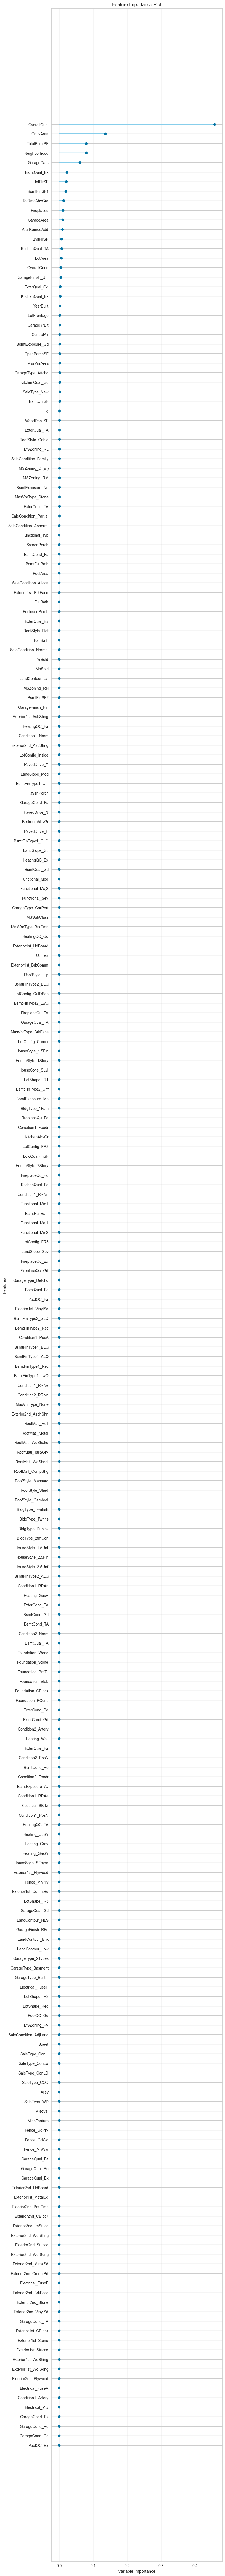

Importancia de características para el modelo GradientBoostingRegressor(random_state=12345)


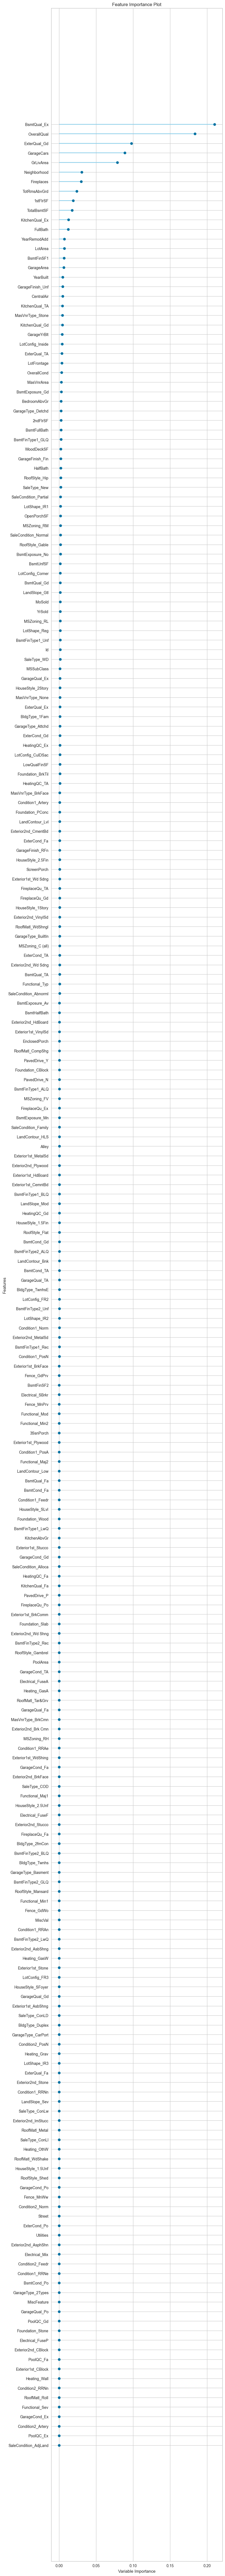

Importancia de características para el modelo ExtraTreesRegressor(random_state=12345)


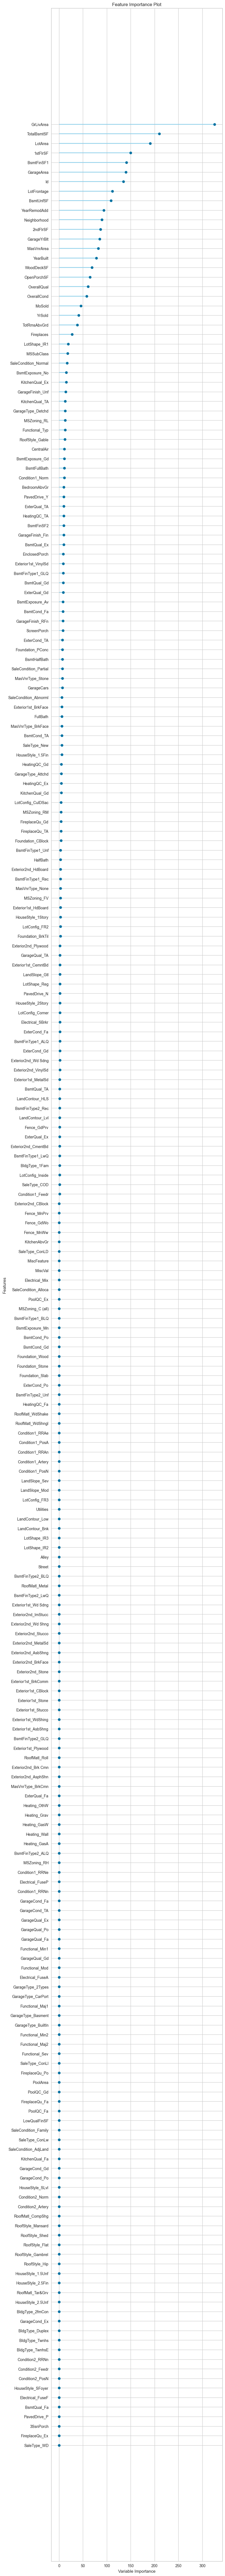

Importancia de características para el modelo LGBMRegressor(random_state=12345)


In [43]:
for model in mejor_modelo:
   
    plot_model(model, plot='feature_all')
    print(f"Importancia de características para el modelo {model}")

### Interpretación  

1. En el modelo gbr las variables "OverallQual", "GrLivArea" y  "TotalBsmiSF" poseen una gran relación con la variable principal SalesPrice

2. En el modelo et las variables "OverallQual", "Bsmtqual_Ex" y  "ExterQual_Gd" poseen una gran relación con la variable principal SalesPrice

3. En el modelo LGBMRegressor las variables "GrLivArea" "TotalBsmiSF" y "Lot area" poseen una gran relación con la variable principal SalesPrice


### 7. Optimización de hiper-parámetros

In [46]:
tuned_model_gbr = tune_model(estimator=primer_modelo)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,14713.6227,431173714.0226,20764.7228,0.8922,0.1772,0.1191
1,18792.7977,882846829.9096,29712.7385,0.9070,0.1276,0.0941
2,19271.5656,753433472.9696,27448.7426,0.9114,0.1457,0.1111
3,16598.0514,850141118.8187,29157.1795,0.8704,0.1278,0.0914
4,15465.8512,493724499.4163,22219.9122,0.9204,0.1293,0.0904
5,19833.3506,1393694755.1716,37332.2214,0.8794,0.1412,0.0974
6,18286.2211,863141777.6797,29379.2746,0.7872,0.1587,0.1176
7,14063.4212,340706678.2274,18458.2415,0.9197,0.1154,0.0863
8,16219.4363,548305770.8666,23415.9299,0.9225,0.1307,0.0956


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [48]:
tuned_model_et = tune_model(estimator=segundo_modelo)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:06:48
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,18211.3746,566623346.9557,23803.8515,0.8584,0.1972,0.1437
1,22552.1362,1818090079.9237,42639.0675,0.8085,0.1755,0.1213
2,20655.6573,980562533.6256,31313.9351,0.8847,0.1654,0.1177
3,18479.2455,836713259.3094,28925.9963,0.8724,0.1602,0.1156
4,20109.1309,927186234.3506,30449.7329,0.8505,0.1585,0.1170
5,24488.5579,2323725503.4849,48205.0361,0.7989,0.1685,0.1132
6,20727.1159,998054024.2671,31591.9930,0.7540,0.2215,0.1595
7,19666.0656,802791166.3065,28333.5696,0.8108,0.1605,0.1153
8,19562.6514,969991289.7237,31144.6832,0.8630,0.1441,0.1068


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### 8. Selección  del  modelo  ﬁnal

El modelo ganador tras realizar la obtimizacion de hiperparametros es: El modelo "et" esto es debido a que tiene un MSE (Error Cuadrático Medio) y RMSE (Error Cuadrático Medio de la Raíz) más bajos en comparación con el modelo Gradient Boosting Regressor. Tambien posee un R2 más alto el cual indica que pude predecir las variables mejor. 

### 9. Almacenamiento del pipeline en el disco duro.

In [50]:
save_model(model=tuned_model_et,model_name='../lab#2/model_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Id', 'MSSubClass', 'LotFrontage',
                                              'LotArea', 'OverallQual',
                                              'OverallCond', 'YearBuilt',
                                              'YearRemodAdd', 'MasVnrArea',
                                              'BsmtFinSF1', 'BsmtFinSF2',
                                              'BsmtUnfSF', 'TotalBsmtSF',
                                              '1stFlrSF', '2ndFlrSF',
                                              'LowQualFinSF', 'GrLivArea',
                                              'BsmtFullBath', 'BsmtHalfBath',
                                              'FullBath', 'Hal...
                                                               use_cat_names=True))),
                 ('rest_encoding',
                  TransformerWrapper(include=['Neighborhood'

### 10. Predicciones

In [52]:
model_final = load_model('../lab#2/model_final')

Transformation Pipeline and Model Successfully Loaded


In [53]:
model_final

Pipeline(memory=FastMemory(location=C:\Users\JOSEL~1\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Id', 'MSSubClass', 'LotFrontage',
                                             'LotArea', 'OverallQual',
                                             'OverallCond', 'YearBuilt',
                                             'YearRemodAdd', 'MasVnrArea',
                                             'BsmtFinSF1', 'BsmtFinSF2',
                                             'BsmtUnfSF', 'TotalBsmtSF',
                                             '1stFlrSF', '2ndFlrSF',
                                             'LowQualFinSF', 'GrLivArea',
                                             'Bs...
                                                              use_cat_names=True))),
                ('rest_encoding',
                 TransformerWrapper(include=['Neighborhood'],
                                    transformer=TargetEncoder(cols=['Neighborhood'],
                                                              handle_missing='return_nan'))),
                ('transformation',
                 TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                ('normalize', TransformerWrapper(transformer=MinMaxScaler())),
                ('trained_model', ExtraTreesRegressor(random_state=12345))])

In [55]:
predicciones = predict_model(model_final, data=data_prueba)
predicciones

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,19715.8272,1453452075.4566,38124.1666,0.7725,0.1582,0.1113


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,prediction_label
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,177752.45
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,225537.50
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,215404.46
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900,147231.00
16,17,20,RL,NaN,11241,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,Shed,700,3,2010,WD,Normal,149000,151279.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,1444,30,RL,NaN,8854,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2009,WD,Normal,121000,121924.00
1447,1448,60,RL,80.0,10000,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2007,WD,Normal,240000,256011.56
1454,1455,20,FV,62.0,7500,Pave,Pave,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,10,2009,WD,Normal,185000,194452.20
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500,240856.68


### 11. Calcular el R2, RMSE, MSE y MAPE.

In [60]:
from sklearn.metrics import r2_score, mean_squared_error

y_true = data_prueba['SalePrice']
y_pred = predicciones['prediction_label']

r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'R2: {r2}')
print(f'RMSE: {rmse}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')

R2: 0.7724943653398912
RMSE: 38124.166554255295
MSE: 1453452075.4565983
MAPE: 11.131556205027666


1. El R2 indica que el modelo explica el 77.25% de la variabilidad de los datos del conjunto de prueba
2. El RMSE es de  38,124 que significa que el modelo de predicciones tiene una variacion de 38,124 en comparacion al modelo original. 
3. El MSE es de  1,453,452,075.46, que es simplemente el cuadrado del RMSE. Al igual que el RMSE, un MSE más bajo indica un mejor ajuste del modelo.
4. Un MAPE del 11.13% indica que, en promedio, las predicciones del modelo difieren en alrededor del 11.13% de las observaciones reales en términos porcentuales. 